# Reactome pathway analysis

## Setup

In [1]:
!pip install reactome2py

In [2]:
from reactome2py import analysis
from matplotlib import pyplot as plt
from pandas import json_normalize
import os, pandas as pd, numpy as np, seaborn as sns
from tqdm import tqdm
from PIL import Image

## Utils

In [3]:
def get_reactome_raw(gene_list):
    
    "Reactome pathway analysis for a given gene set; returns raw output in dataframe."
    
    gene_str = ','.join(gene_list)
    
    # set page size and page to -1 ensures to display all pathway results, sort by pvalue instead of fdr, projection set to True is consistent with official web
    result = analysis.identifiers(gene_str, page_size='-1', page='-1', sort_by='ENTITIES_PVALUE',projection=True)
    
    out = json_normalize(result['pathways'])
    
    return out

Example:

In [4]:
# get gene list
genes = pd.read_csv('raw/AKT1.csv')['gene'].tolist()

get_reactome_raw(genes).head()

,stId,dbId,name,llp,inDisease,species.dbId,species.taxId,species.name,entities.resource,entities.total,entities.found,entities.ratio,entities.pValue,entities.fdr,entities.exp,reactions.resource,reactions.total,reactions.found,reactions.ratio
0,R-HSA-111465,111465,Apoptotic cleavage of cellular proteins,True,False,48887,9606,Homo sapiens,TOTAL,38,33,0.002428,0.000134,0.322956,[],TOTAL,38,38,0.002506
1,R-HSA-5674400,5674400,Constitutive Signaling by AKT1 E17K in Cancer,True,True,48887,9606,Homo sapiens,TOTAL,29,25,0.001853,0.000889,0.878858,[],TOTAL,18,18,0.001187
2,R-HSA-75153,75153,Apoptotic execution phase,True,False,48887,9606,Homo sapiens,TOTAL,54,39,0.003450,0.001225,0.878858,[],TOTAL,57,57,0.003759
3,R-HSA-3108232,3108232,SUMO E3 ligases SUMOylate target proteins,False,False,48887,9606,Homo sapiens,TOTAL,184,104,0.011755,0.002371,0.878858,[],TOTAL,132,102,0.008705
4,R-HSA-2990846,2990846,SUMOylation,False,False,48887,9606,Homo sapiens,TOTAL,193,107,0.012330,0.003650,0.878858,[],TOTAL,141,111,0.009298


In [5]:
def plot_path(react_out, top_n=10,max_label_length=80):

    "Plot the output of get_reactome."
    
    # Extract the data and reverse it
    data = react_out.head(top_n).set_index('name')['-log10_pValue'].iloc[::-1]
    
    # Truncate labels if they are too long
    truncated_labels = [label[:max_label_length] + '...' if len(label) > max_label_length else label for label in data.index]
    data.index = truncated_labels

    # Calculate the required width: base width + additional width for the longest label
    base_width = 2
    max_label_length = max(data.index, key=len)
    additional_width = len(max_label_length) * 0.1  # Adjust scaling factor as needed
    
    figsize = (base_width + additional_width, 3*top_n/10)  # Adjust height as necessary

    # Plotting
    data.plot.barh(figsize=figsize)
    plt.ylabel('')
    plt.xlabel('-log10(p)')
    plt.tight_layout()  # Adjust layout to fit everything

In [6]:
def get_reactome(gene_list, plot=True):
    
    "Given a gene list, get the processed output of reactome; output contains additional -log10(p)"
    out = get_reactome_raw(gene_list)
    out = out[['name','entities.pValue']].rename(columns={'entities.pValue':'pValue'})
    out['-log10_pValue'] = -np.log10(out['pValue']).round(3)

    if plot:
        plot_path
    
    return out

In [7]:
out = get_reactome(genes)
out.head()

,name,pValue,-log10_pValue
0,Apoptotic cleavage of cellular proteins,0.000134,3.874
1,Constitutive Signaling by AKT1 E17K in Cancer,0.000889,3.051
2,Apoptotic execution phase,0.001225,2.912
3,SUMO E3 ligases SUMOylate target proteins,0.002371,2.625
4,SUMOylation,0.003650,2.438


In [8]:
sns.set(rc={"figure.dpi":300, 'savefig.dpi':300})
sns.set_context('notebook')
sns.set_style("ticks")

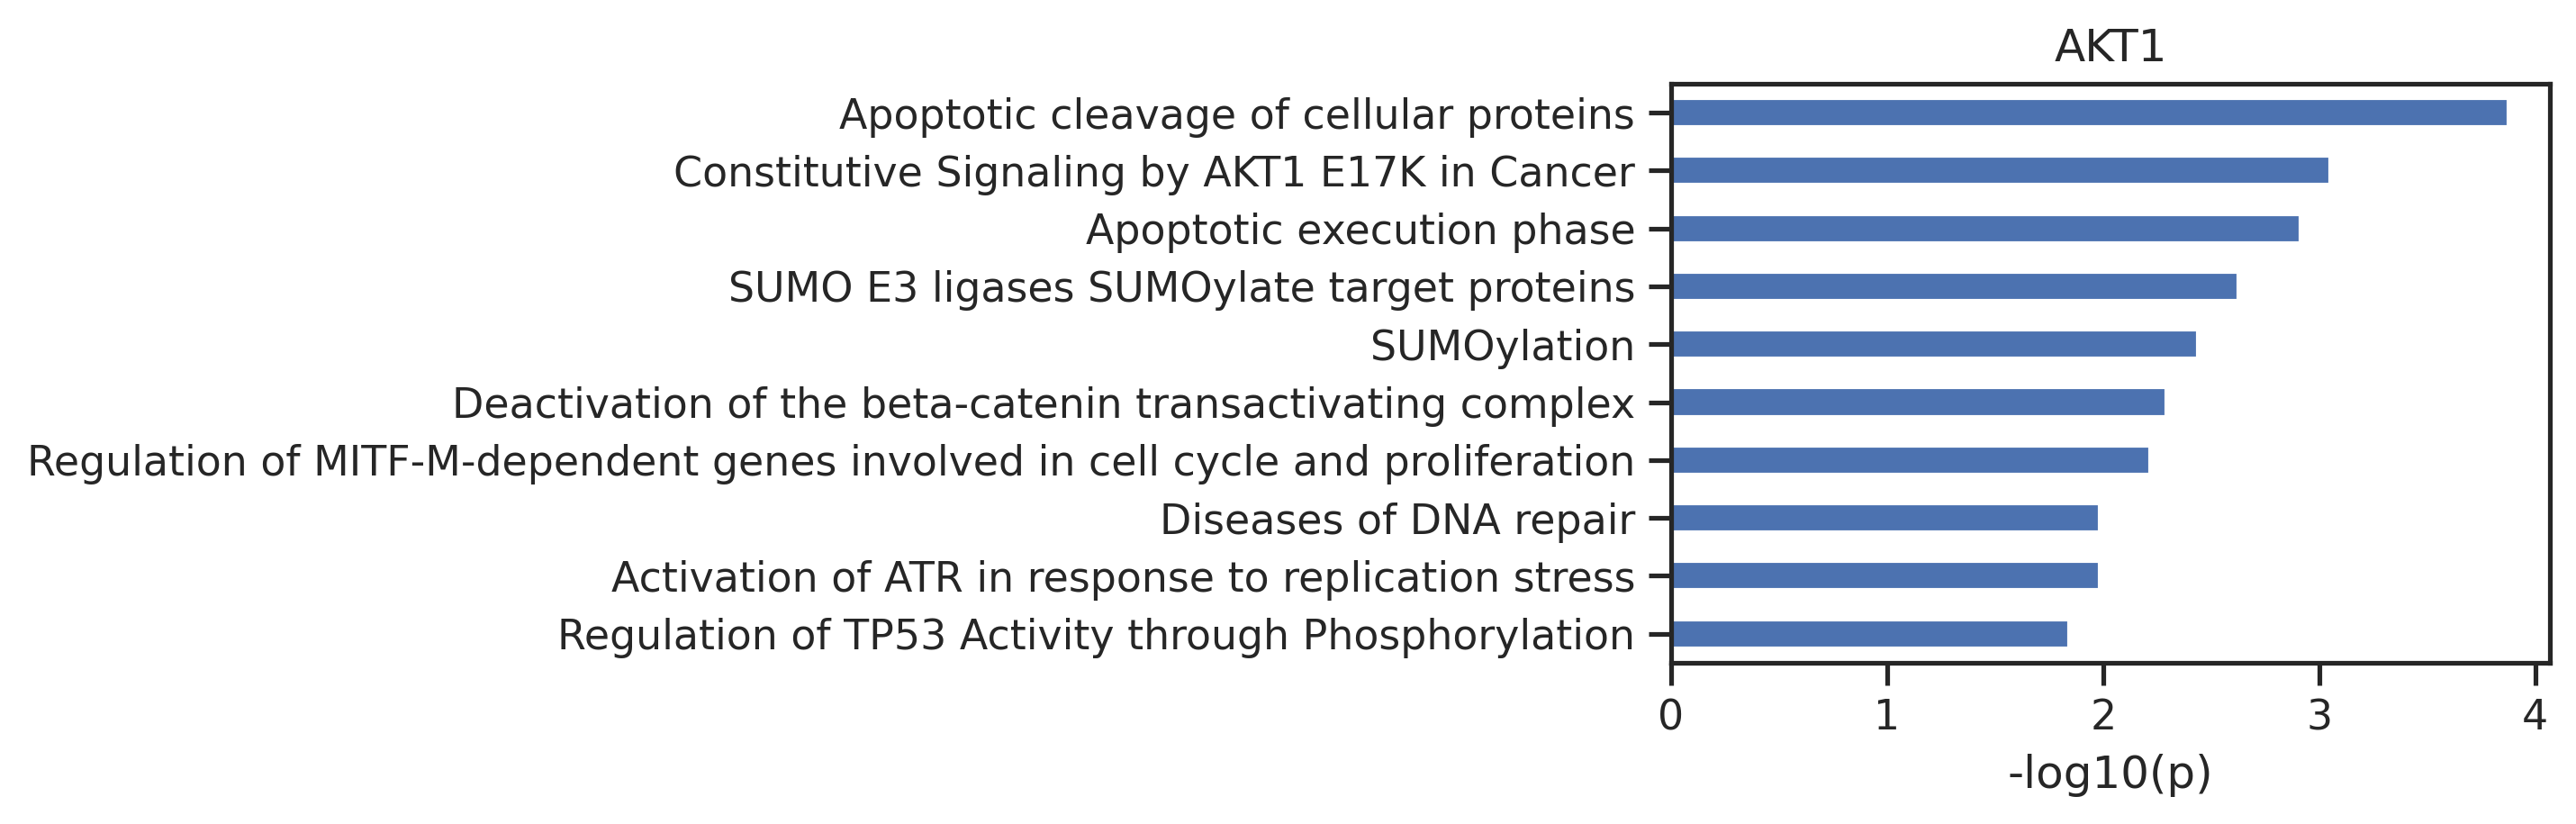

In [10]:
plot_path(out)
plt.title('AKT1');

## Run

In [11]:
from katlas.core import *
from katlas.plot import *

For the original human phosphoproteome (all-uppercase):

In [12]:
site= Data.get_combine_site_psp_ochoa()

For phosphorylated human phosphoproteome, uncheck below:

In [13]:
# site = Data.get_combine_site_phosphorylated()

For PSP site, uncheck below:

In [14]:
# site = Data.get_psp_human_site()

# site['acceptor'] = site.site_seq.str[7]

# # remove none sty-phosphoacceptor sequence
# site = site['acceptor'].isin(['s','t','y'])]

# # convert lowercase other than s,t,y to capital; convert rare aa to _
# site['site_seq'] = site.site_seq.apply(convert_string)

# site = site.reset_index(drop=True)

# site.to_parquet('PSP_human_processed_sites.parquet')

# site = pd.read_parquet('PSP_human_processed_sites.parquet')

As the original phosphoproteome is an all-uppercase dataset, we choose param to be `param_CDDM_upper`

In [15]:
param = param_CDDM_upper

## for phosphorylated dataset, we will choose the standard param
# param = param_CDDM
## or
# param = param_PSPA

In [16]:
ref = param['ref']

In [17]:
results = predict_kinase_df(site,'site_seq',**param)

input dataframe has a length 121419
Preprocessing
Finish preprocessing
Merging reference
Finish merging


In [18]:
result_df = pd.concat([site,results],axis=1)

## Plot score distribution

In [19]:
result_df['acceptor'] =  result_df.site_seq.str[7].str.upper()

In [20]:
palette = get_color_dict(['S','T','Y'],'tab20')

hist_params = {'element':'poly',
              'edgecolor': None,
              'alpha':0.5,
              'bins':100,
              'kde':True,
              'palette':palette}

In [21]:
palette

{'S': (0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
 'T': (0.6823529411764706, 0.7803921568627451, 0.9098039215686274),
 'Y': (1.0, 0.4980392156862745, 0.054901960784313725)}

In [22]:
def plot_hist(df,colname,sty_thr=None,hue='acceptor'):
    
    "Plot histogram of a column (kinase). "
    
    plt.figure(figsize=(6,2))
    
    sns.histplot(data=df,x=colname,hue=hue,**hist_params)
    
    plt.xlabel('')
    plt.title(colname)

    if sty_thr:
        for acceptor,thr in sty_thr.items():
            if thr is not None:
                plt.axvline(thr,color=palette[acceptor])

## Ratio method to determine threshold

- Step1: Locate the max phosphoacceptor in the STY ratio of a kinase
- Step2: Get top 2% sites for that phosphoacceptor, and get the number of sites.
- Step3: Use the number and STY ratio to calculate the number of sites for other phosphoacceptor.

In [23]:
def get_ratio(df, kinase, ref, pct=0.98):
    # Copy relevant columns and explode gene column
    data = df[['gene', 'acceptor', kinase]].copy()
    data['gene'] = data.gene.str.split('|')
    data = data.explode('gene')

    # Get STY ratio from reference data
    row = ref[['0S', '0T', '0Y']].loc[kinase]
    if row['0Y'] > 0.8: # apply to pspa
        ratio = {'S': 0, 'T': 0, 'Y': 1}
    elif 0.1 < row['0Y'] < 0.8: # does not apply to pspa
        ratio = {'S': row['0S'], 'T': row['0T'], 'Y': row['0Y']}
    else: # apply to pspa
        total = row['0S'] + row['0T']
        ratio = {'S': row['0S'] / total, 'T': row['0T'] / total, 'Y': 0}

    # Calculate thresholds and get genes
    sty_thr = {'S': None, 'T': None, 'Y': None}
    g_list = []

    # Identify the largest acceptor and calculate its total for top percentile
    max_acceptor = max(ratio, key=ratio.get)
    max_data = data[data['acceptor'] == max_acceptor]

    thr = max_data[kinase].quantile(pct)
    top_max_data = max_data[max_data[kinase]>thr]
    top_total = len(top_max_data)
    
    threshold_max = top_max_data[kinase].min()

    # Scale other acceptors and get the threshold
    for acceptor in ['S', 'T', 'Y']:
        if ratio[acceptor] != 0:
            scaled_data = data[data['acceptor'] == acceptor]
            scaled_data = scaled_data.sort_values(kinase, ascending=False)
            n_top = int(top_total * (ratio[acceptor] / ratio[max_acceptor]))
            top_scaled_data = scaled_data.head(n_top)
            

            g_list.append(top_scaled_data['gene'])
            sty_thr[acceptor] = top_scaled_data[kinase].min()

    genes = pd.concat(g_list).drop_duplicates().dropna().tolist()

    return sty_thr, genes

## Pipeline

1. Get threshold and genes within the percentiile

In [24]:
k = 'ATM'

In [25]:
sty_threshold,genes = get_ratio(result_df,k,ref=ref)

In [26]:
sty_threshold

{'S': 2.6404023, 'T': 1.9869915, 'Y': None}

2. with threshold, plot score distribute

In [27]:
sns.set(rc={"figure.dpi":300, 'savefig.dpi':300})
sns.set_context('notebook')
sns.set_style("ticks")

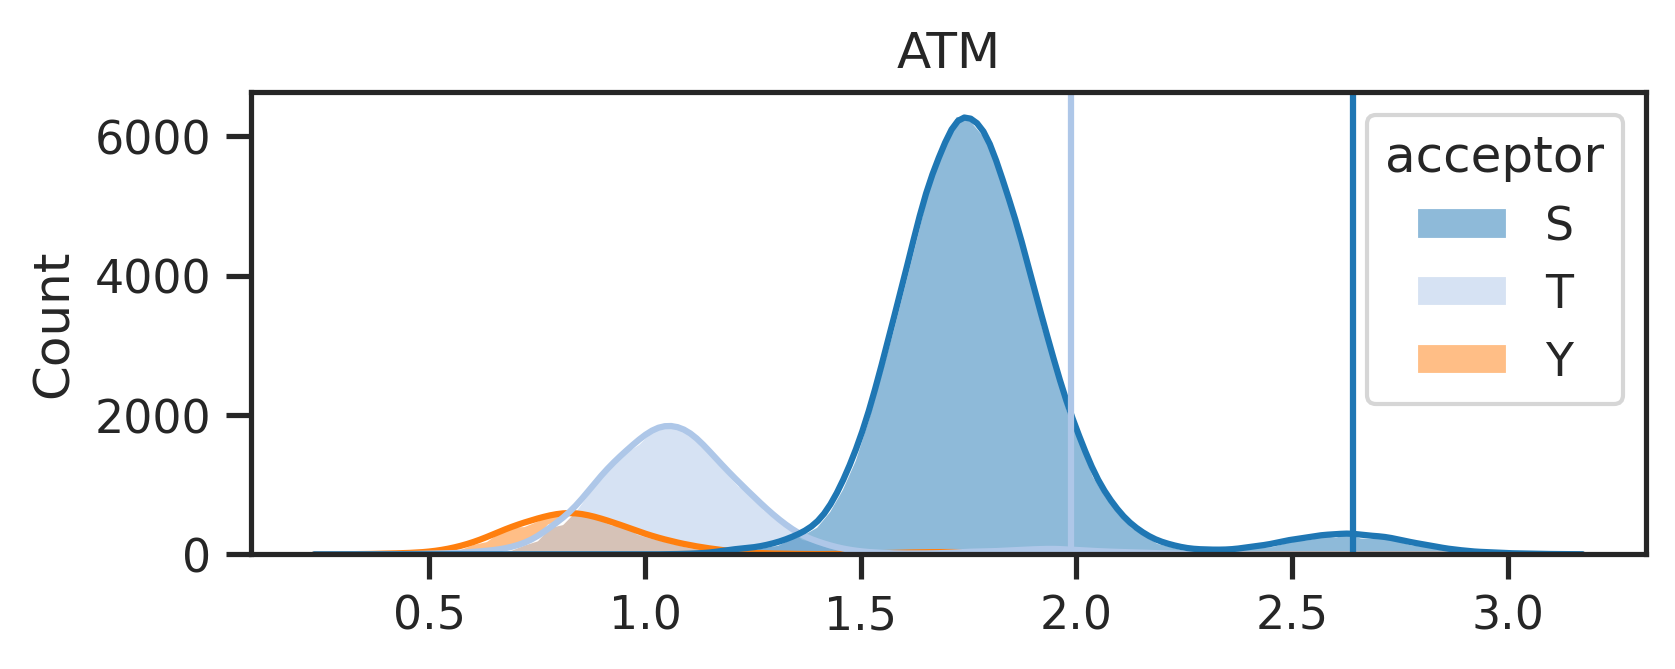

In [28]:
plot_hist(result_df,k,sty_threshold)

3. run reactoe pathway analysis

In [29]:
out = get_reactome(genes)

In [30]:
# exclude paths that has no variance across kinases
exclude=['GTPase','SUMO']
for n in exclude:
    out = out[~out.name.str.contains(n)]

4. plot path

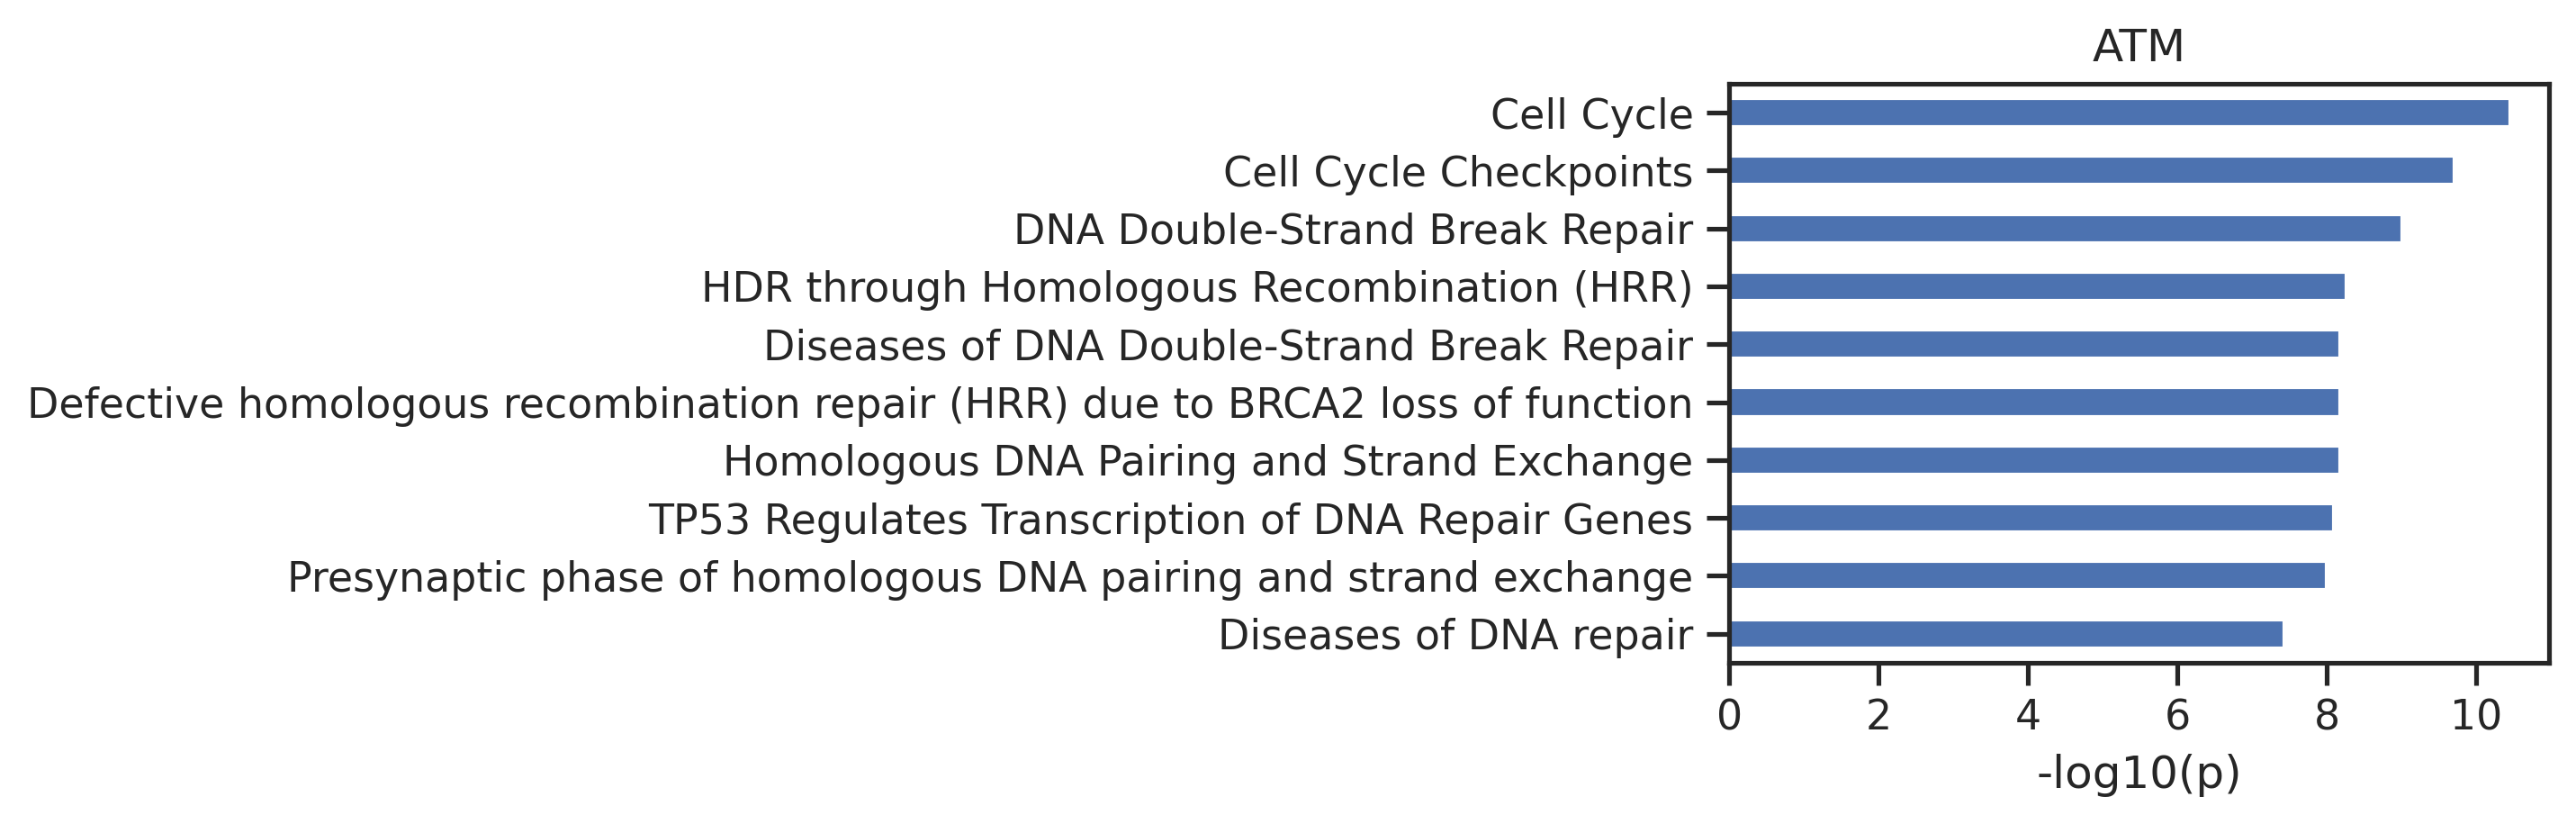

In [31]:
plot_path(out,10)
plt.title(k);

## Run all kinases and save images

In [50]:
from pathlib import Path
from fastcore.xtras import *

In [54]:
def get_img(df, kinase_list, ref, SAVE=False,save_folder='cddm',exclude=['GTPase','SUMO'],pct=0.98):

    paths = []
    for kinase in tqdm(kinase_list):

        sty_thr,genes = get_ratio(df,kinase,ref=ref,pct=pct)

        out = get_reactome(genes)

        out['kinase'] = kinase
        paths.append(out)

        # plot score distribution
        plot_hist(df,kinase,sty_thr)

        distribute_figname = Path(f'{save_folder}/score_distribute/{kinase}.png')
        distribute_figname.parent.mkdir(parents=True,exist_ok=True)
        
        plt.savefig(distribute_figname,bbox_inches='tight', pad_inches=0.3) if SAVE else plt.show()
        plt.close()


        # exclude paths that has no variance across kinases
        out_cut = out.copy()
        for n in exclude:
            out_cut = out_cut[~out_cut.name.str.contains(n)]
            
        # plot pathway bargraph
        plot_path(out_cut,10)
        
        # title_acceptor ='/'.join(acceptors)
        # plt.title(f'{kinase}, top 2% substrates in {title_acceptor} sites')

        path_figname = Path(f'{save_folder}/path_fig/{kinase}.png')
        path_figname.parent.mkdir(parents=True,exist_ok=True)
        
        plt.savefig(path_figname,bbox_inches='tight', pad_inches=0) if SAVE else plt.show()
        plt.close()
    return paths

  0%|          | 0/3 [00:00<?, ?it/s]

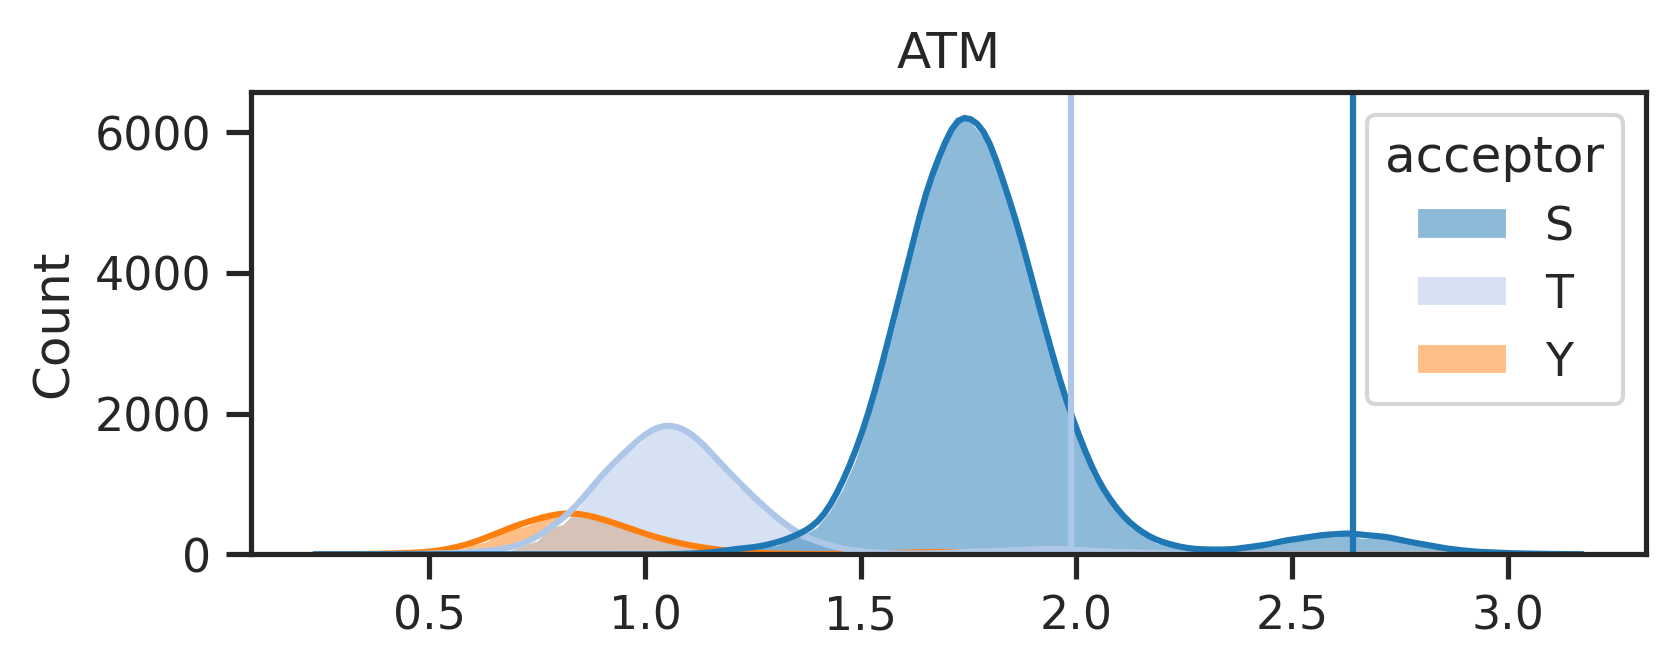

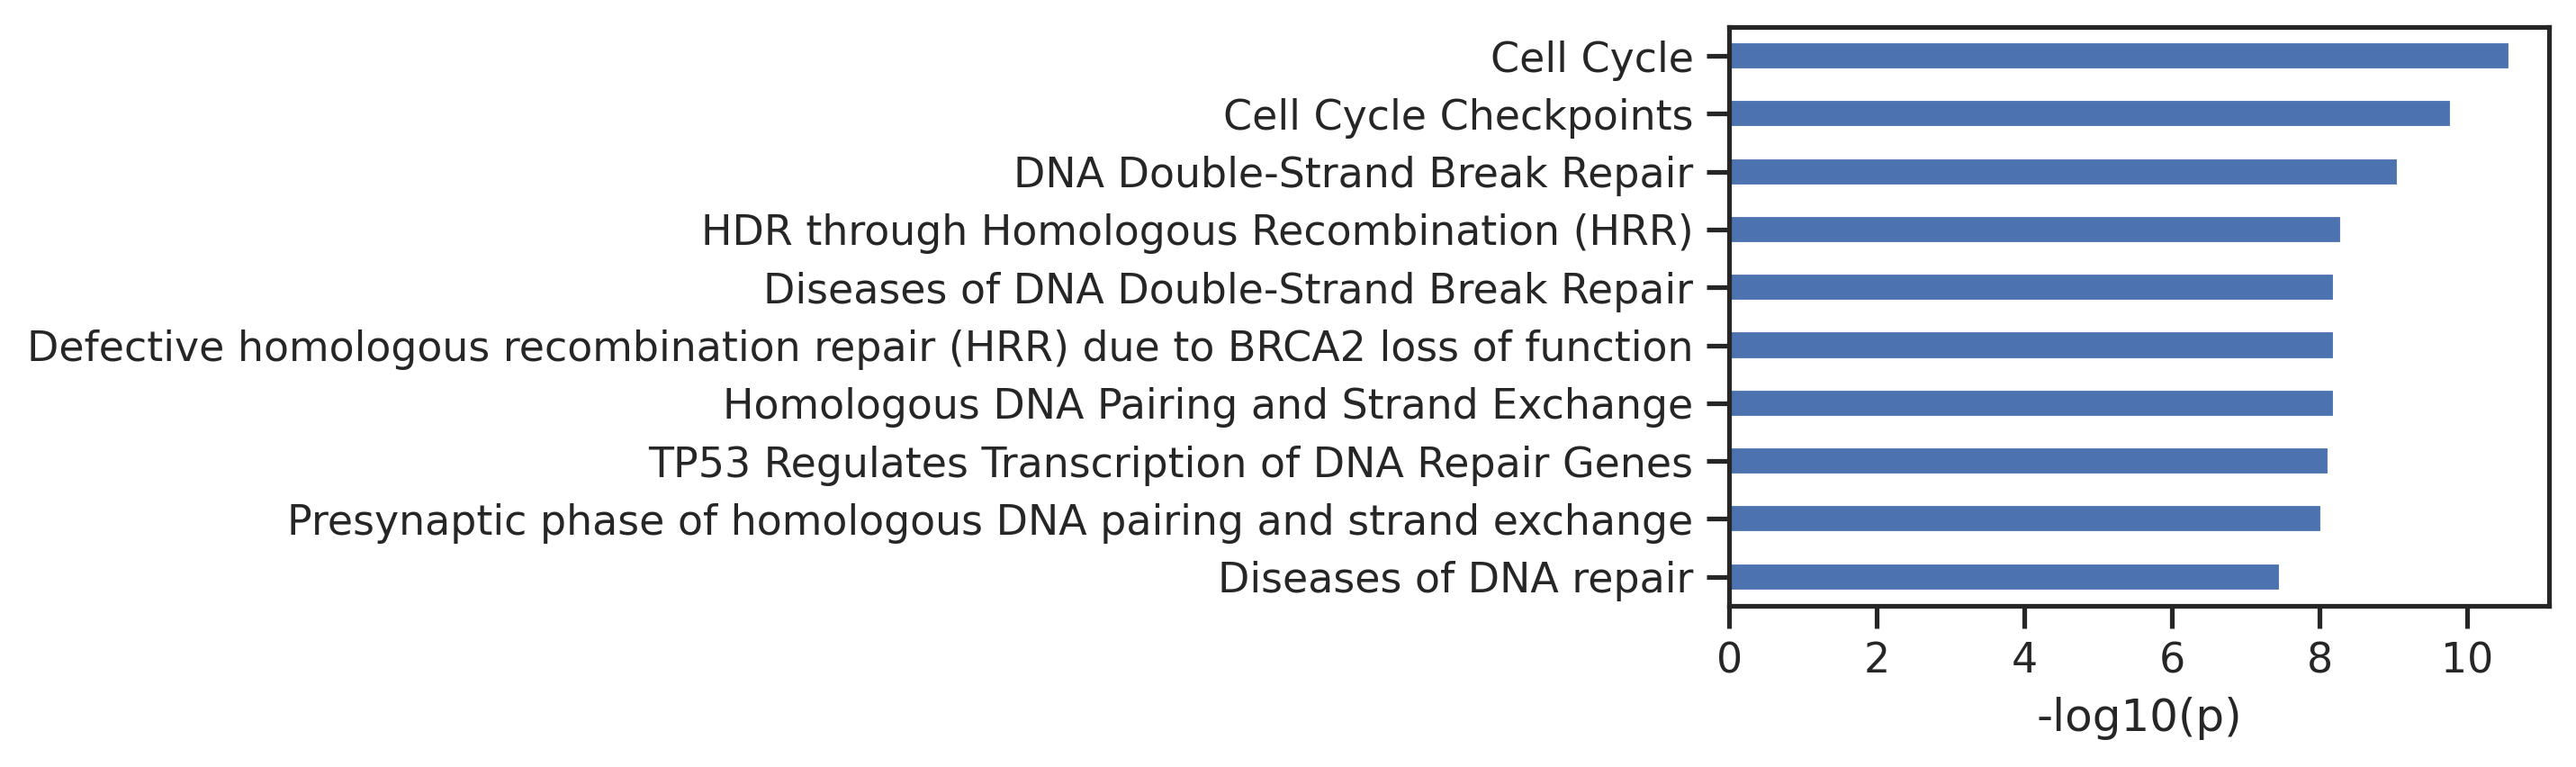

 33%|███▎      | 1/3 [00:01<00:02,  1.39s/it]

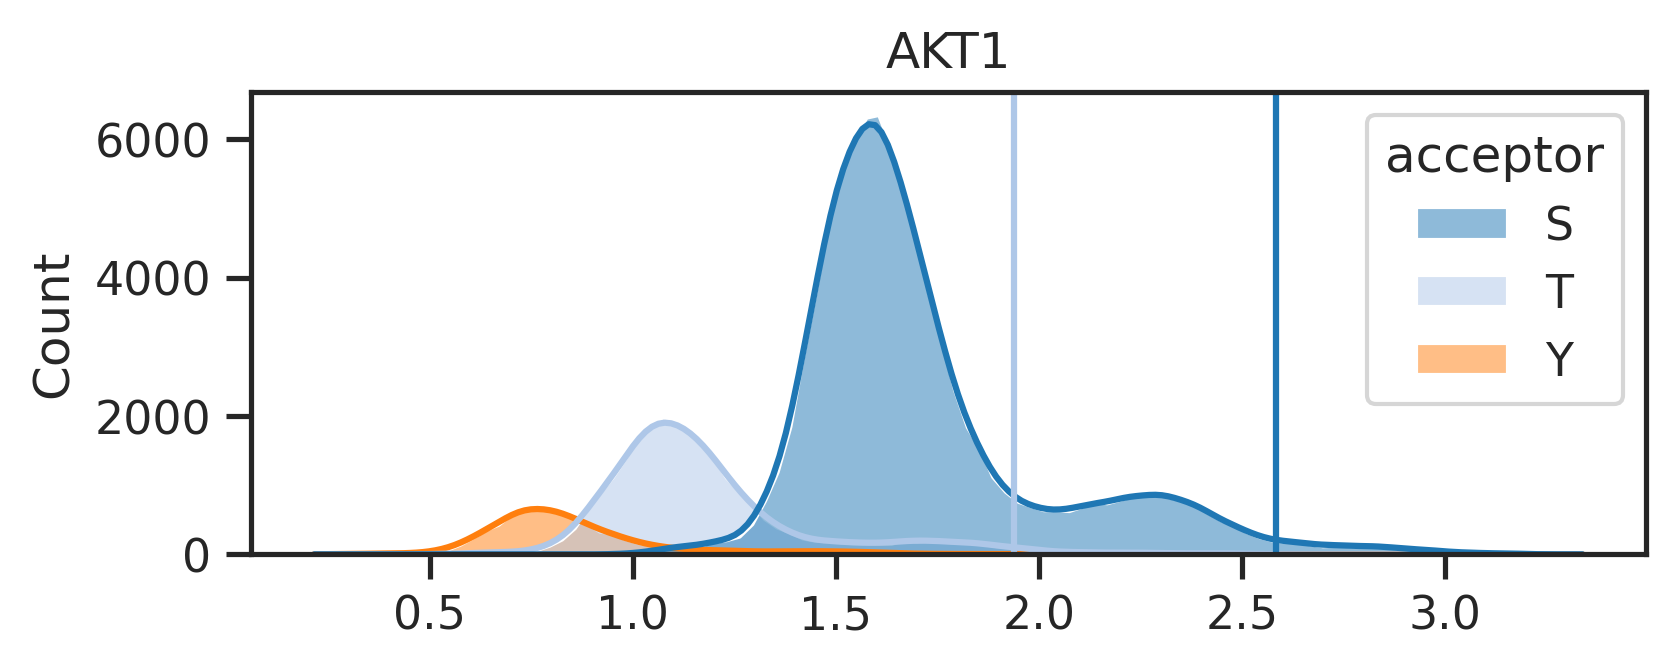

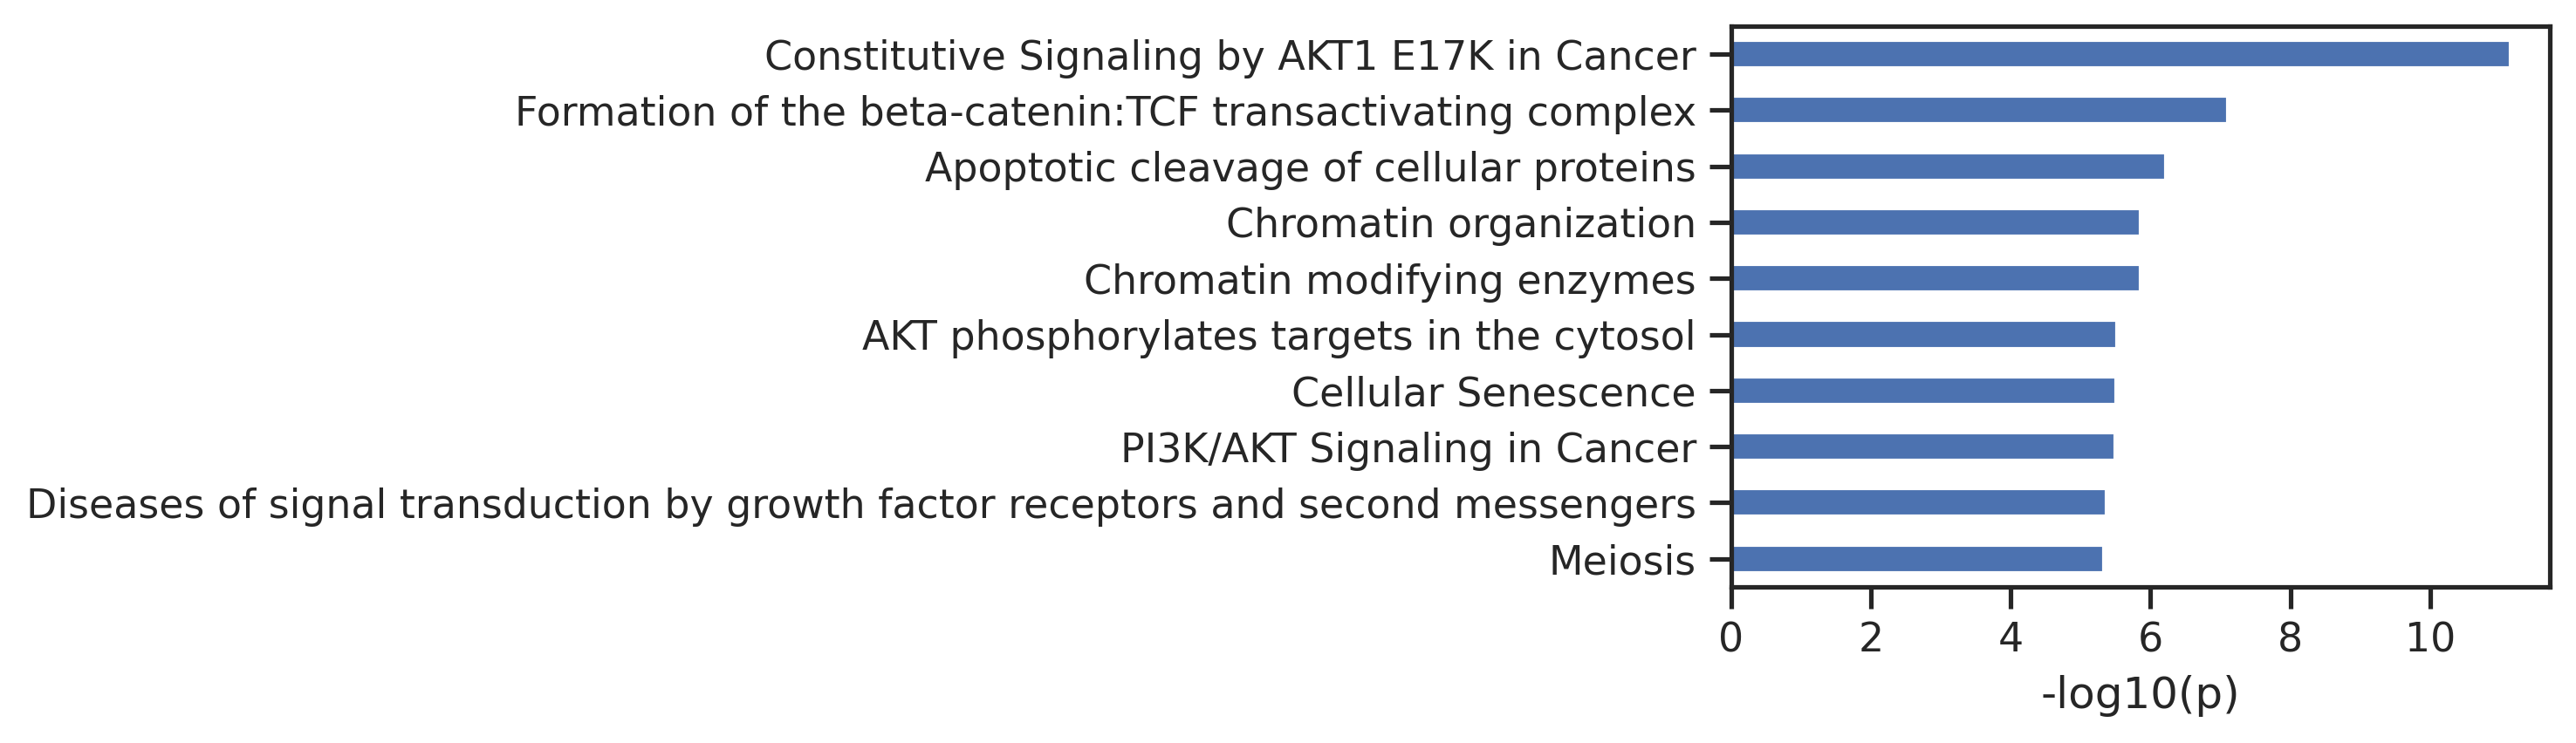

 67%|██████▋   | 2/3 [00:02<00:01,  1.32s/it]

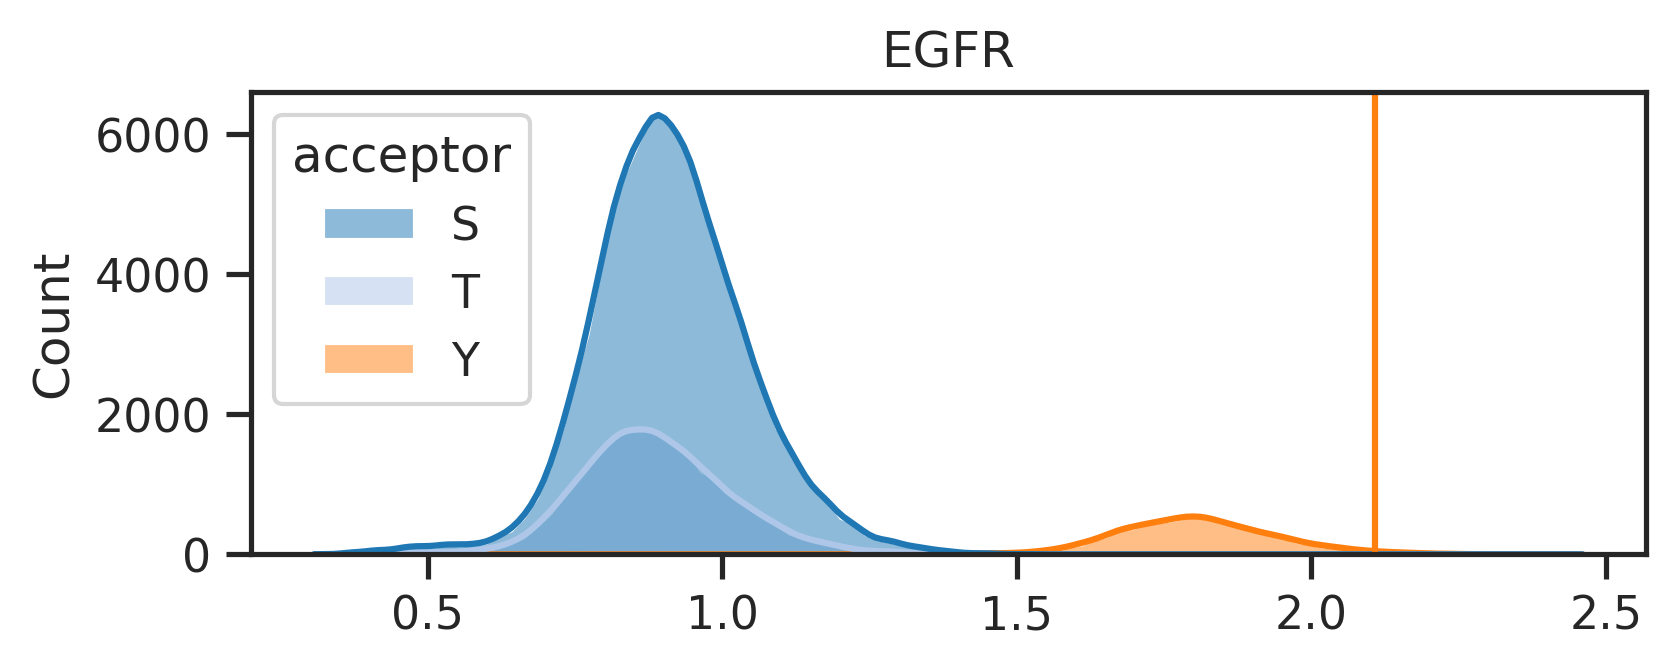

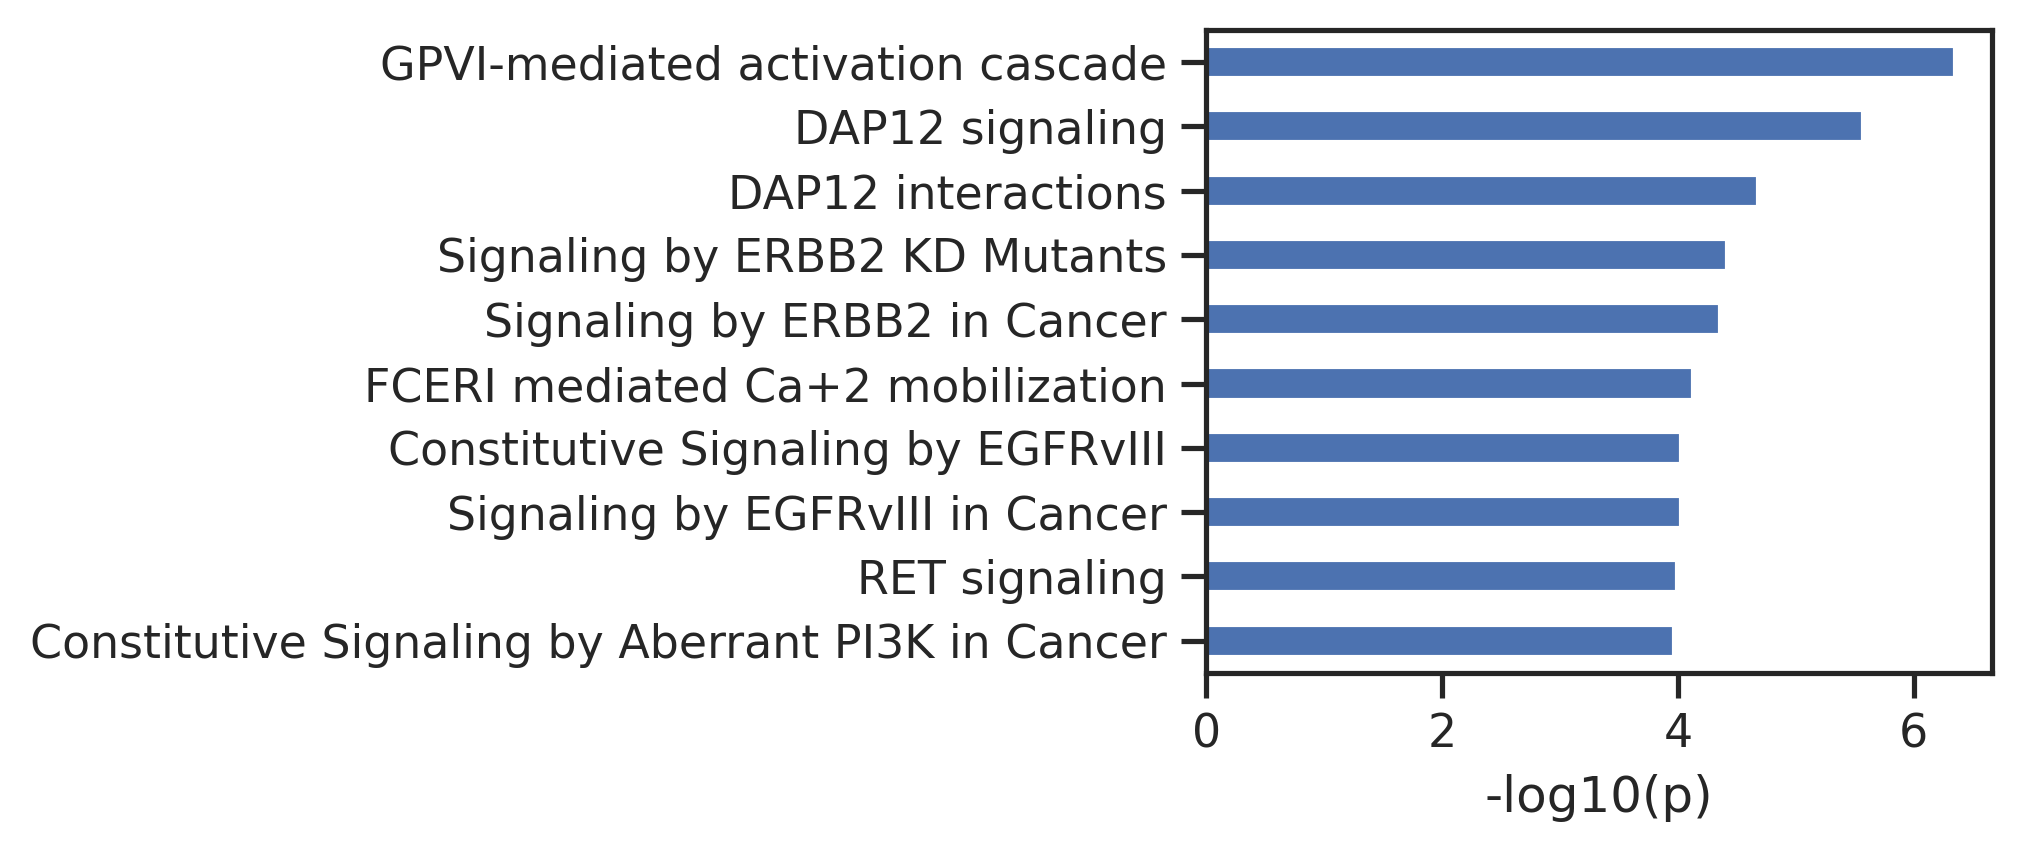

100%|██████████| 3/3 [00:03<00:00,  1.32s/it]


In [60]:
paths = get_img(result_df,['ATM','AKT1','EGFR'],ref,SAVE=False,save_folder='test')

Uncheck below to generate figures for all of the kinases:

In [32]:
# paths = get_img(result_df,ref.index,ref,SAVE=True,save_folder='test')

The above line will create two folders under the {save_folder}: 
- path_fig folder contains the pathway analysis.
- score_distribute folder contains histogram of score distribution.

## Combine images for pdf

In [33]:
def combine_images_vertically(image_paths, output_path):
    # Open images and convert them to 'RGBA' for uniformity
    images = [Image.open(image_path).convert('RGBA') for image_path in image_paths]
    
    # Calculate the total width as the maximum width of any image
    total_width = max(image.width for image in images)
    # Calculate the total height by summing the heights of all images
    total_height = sum(image.height for image in images)
    
    # set the background white board size
    # total_width, total_height = 2010,1200
    total_width, total_height = 3000,1750

    # Create a new image with a white background in 'RGBA' mode
    combined_image = Image.new('RGBA', (total_width, total_height), (255, 255, 255, 255))

    # Initialize the y_offset to start pasting images from the top
    y_offset = 0
    for image in images:
        # Calculate the x position to center the image
        x_offset = (total_width - image.width) // 2
        # Paste the current image into the combined image
        combined_image.paste(image, (x_offset, y_offset), image)
        # Update the y_offset to move to the next position for the next image
        y_offset += image.height

    # Save the combined image to the specified output path
    combined_image.save(output_path)

Uncheck below to merge the pathway figures and score distribution figures together:

In [34]:
# folders = ["test/score_distribute", "test/path_fig"]
# for k in tqdm(ref.index):
#     filename = f"{k}.png"
#     image_paths = [os.path.join(folder, filename) for folder in folders]
#     output_path = Path(f"test/combine/{k}.png")
#     output_path.parent.mkdir(parents=True,exist_ok=True)
    
#     combine_images_vertically(image_paths, output_path)

## Save path in csv

Uncheck below to save pathway csv:

In [36]:
# path_data = pd.concat(paths)

# path_data = path_data[['kinase','name','pValue','-log10_pValue']]

# path_data.columns = ['kinase','Reactome_pathway','pValue','neg_log10_pValue']

# path_data.to_csv('pathway_analysis.csv',index=False)